In [1]:
#!/usr/bin/python 3.6
#-*-coding:utf-8-*-

'''
DeepAR Model (Pytorch Implementation)
Paper Link: https://arxiv.org/abs/1704.04110
Author: Jing Wang (jingw2@foxmail.com)
'''

import torch 
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import date
import argparse
from progressbar import *
from util import *

In [2]:
class Gaussian(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)
    
    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        mu_t = self.mu_layer(h)
        return mu_t, sigma_t

class NegativeBinomial(nn.Module):

    def __init__(self, input_size, output_size):
        '''
        Negative Binomial Supports Positive Count Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(NegativeBinomial, self).__init__()
        self.mu_layer = nn.Linear(input_size, output_size)
        self.sigma_layer = nn.Linear(input_size, output_size)
    
    def forward(self, h):
        _, hidden_size = h.size()
        alpha_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        mu_t = torch.log(1 + torch.exp(self.mu_layer(h)))
        return mu_t, alpha_t

def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation

    gaussian maximum likelihood using log 
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample()
    return ypred

def negative_binomial_sample(mu, alpha):
    '''
    Negative Binomial Sample
    Args:
    ytrue (array like)
    mu (array like)
    alpha (array like)

    maximuze log l_{nb} = log Gamma(z + 1/alpha) - log Gamma(z + 1) - log Gamma(1 / alpha)
                - 1 / alpha * log (1 + alpha * mu) + z * log (alpha * mu / (1 + alpha * mu))

    minimize loss = - log l_{nb}

    Note: torch.lgamma: log Gamma function
    '''
    var = mu + mu * mu * alpha
    ypred = mu + torch.randn() * torch.sqrt(var)
    return ypred

In [3]:
class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        if likelihood == "g":
            self.likelihood_layer = Gaussian(hidden_size, 1)
        elif likelihood == "nb":
            self.likelihood_layer = NegativeBinomial(hidden_size, 1)
        self.likelihood = likelihood
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (array like): shape (num_time_series, seq_len, input_size)
        y (array like): shape (num_time_series, seq_len)
        Xf (array like): shape (num_time_series, horizon, input_size)
        Return:
        mu (array like): shape (batch_size, seq_len)
        sigma (array like): shape (batch_size, seq_len)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_obs_to_train, _ = X.size()
        _, seq_len, num_features = Xf.size()
        ynext = None
        ypred = []
        mus = []
        sigmas = []
        h, c = None, None
        for s in range(num_obs_to_train + seq_len):
            if s < num_obs_to_train:
                if s ==0: ynext = torch.zeros((num_ts, 1)).to(device)
                else: ynext = y[:, s-1].view(-1, 1)
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = X[:, s, :].view(num_ts, -1)
            else:
                if s == num_obs_to_train: ynext = y[:, s-1].view(-1, 1)
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = Xf[:, s-num_obs_to_train, :].view(num_ts, -1)
            x = torch.cat([x, yembed], dim=1) # num_ts, num_features + embedding
            inp = x.unsqueeze(1)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))
            hs = h[-1, :, :]
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            if self.likelihood == "g":
                ynext = gaussian_sample(mu, sigma)
            elif self.likelihood == "nb":
                alpha_t = sigma
                mu_t = mu
                ynext = negative_binomial_sample(mu_t, alpha_t)
            # if without true value, use prediction
            if s >= num_obs_to_train and s < num_obs_to_train + seq_len:
                ypred.append(ynext)
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma
    


Load Data

In [4]:
num_epoches = 100
step_per_epoch = 3
lr = 1e-3
n_layers = 1
hidden_size = 50
embedding_size = 10
likelihood = "g"
seq_len = 60
num_obs_to_train = 168
num_results_to_sample = 10
show_plot = True
run_test = True
standard_scaler = True
log_scaler = False
mean_scaler = False
batch_size = 64
sample_size = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(1440, 5)


,date,hour,MT_200,year,day_of_week
26304,2014-01-01,0,1367.841410,2014,2
26305,2014-01-01,1,1365.638767,2014,2
26306,2014-01-01,2,1324.889868,2014,2
26307,2014-01-01,3,1261.013216,2014,2
26308,2014-01-01,4,1243.392070,2014,2


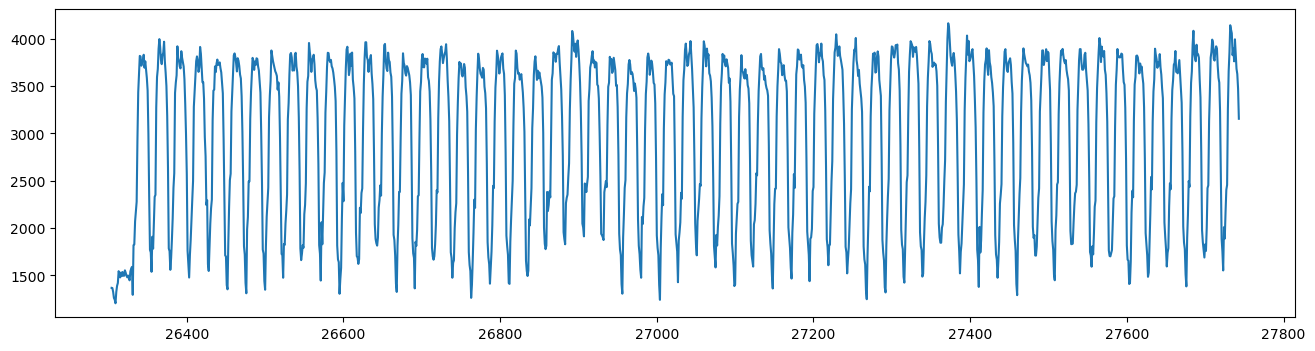

In [5]:
data = pd.read_csv("LD_MT200_hour.csv", parse_dates = ["date"])
data["year"] = data["date"].apply(lambda x: x.year)
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
data = data.loc[(data["date"].dt.date >= date(2014, 1, 1)) & (data["date"].dt.date <= date(2014, 3, 1))]
print(data.shape)
plt.figure(figsize=(16,4))
plt.plot(data['MT_200'])
data.head()

In [6]:
features = ["hour", "day_of_week"]

years = data["year"]
hours = data["hour"]
dows = data["day_of_week"]

X = np.c_[np.asarray(hours),np.asarray(dows)]
num_features = X.shape[1]
num_periods = len(data)
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
print("X_shape = ", X.shape)
print("y_shape", y.shape)

X_shape =  (1, 1440, 2)
y_shape (1, 1440)


In [7]:
def sliding_window(DataSet, width, multi_vector = True):
    if multi_vector:
        num_samples, length, features = DataSet.shape
    else:
        DataSet = DataSet[:,:,np.newaxis]
        num_samples, length, features = DataSet.shape

    x = DataSet[:,0:width,:]
    x = x[np.newaxis,:,:,:]
    for i in range(length - width):
        i += 1
        tmp = DataSet[:,i:i+width,:]
        tmp = tmp[np.newaxis,:,:,:]
        x = np.concatenate([x,tmp],0)
    return x

width = num_obs_to_train + seq_len
X_data = sliding_window(X, width, multi_vector = True)
Y_data = sliding_window(y, width, multi_vector= False)
print("x data shape: ", X_data.shape)
print("y data shape: ", Y_data.shape)

i = 0
X_data = X_data[:,i,:,:]
Y_data = Y_data[:,i,:,0]
print("x data shape: ", X_data.shape)
print("y data shape: ", Y_data.shape)

x data shape:  (1213, 1, 228, 2)
y data shape:  (1213, 1, 228, 1)
x data shape:  (1213, 228, 2)
y data shape:  (1213, 228)


In [8]:
# SPLIT TRAIN TEST
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X_data, Y_data,
                                      test_size=0.3,
                                      random_state=0,
                                      shuffle=False)
print("X_train:{}, y_train:{}".format(Xtr.shape, ytr.shape))
print("X_test:{}, y_test:{}".format(Xtr.shape, ytr.shape))


X_train:(849, 228, 2), y_train:(849, 228)
X_test:(849, 228, 2), y_test:(849, 228)


In [9]:
yscaler = None
if standard_scaler:
    yscaler = StandardScaler()
elif log_scaler:
    yscaler = LogScaler()
elif mean_scaler:
    yscaler = MeanScaler()
if yscaler is not None:
    ytr = yscaler.fit_transform(ytr)

In [10]:
Xtr = torch.as_tensor(torch.from_numpy(Xtr), dtype = torch.float32)
ytr = torch.as_tensor(torch.from_numpy(ytr), dtype = torch.float32)
Xte = torch.as_tensor(torch.from_numpy(Xte), dtype = torch.float32)
yte = torch.as_tensor(torch.from_numpy(yte), dtype = torch.float32)

train_dataset = torch.utils.data.TensorDataset(Xtr,ytr)
train_Loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)

Training


100% |########################################################################|


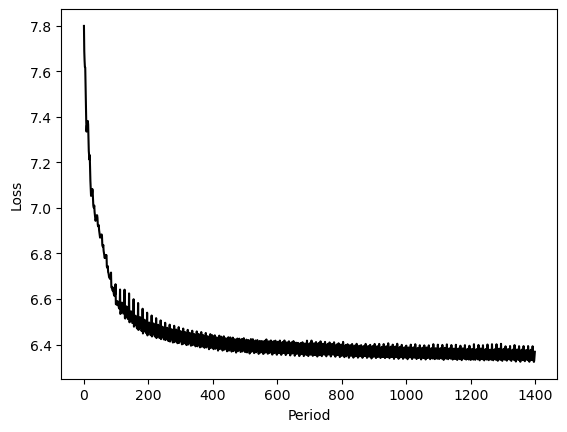

In [13]:
num_ts, num_periods, num_features = X.shape
model = DeepAR(num_features, embedding_size,
    hidden_size, n_layers, lr, likelihood).to(device)
optimizer = Adam(model.parameters(), lr = lr)
random.seed(2)

losses = []
cnt = 0

# Training
print("Training")
progress = ProgressBar()
for epoch in progress(range(num_epoches)):
    for x,y in train_Loader:
        x = x.to(device)
        y = y.to(device)
        Xtrain = x[:,:num_obs_to_train,:].float()
        ytrain = y[:,:num_obs_to_train].float()
        Xf = x[:,-seq_len:,:].float()
        yf = y[:,-seq_len:].float()

        ypred, mu, sigma = model(Xtrain, ytrain, Xf)



        ytrain = torch.cat([ytrain, yf], dim=1)
        if likelihood == "g":
            loss = gaussian_likelihood_loss(ytrain, mu, sigma)
        elif likelihood == "nb":
            loss = negative_binomial_loss(ytrain, mu, sigma)
        losses.append(loss.item())



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt += 1

if show_plot:
    plt.plot(range(len(losses)), losses, "k-")
    plt.xlabel("Period")
    plt.ylabel("Loss")
    plt.show()



In [1]:
print("Testing")
X_test_sample = Xte[:,:,:].reshape(-1, num_obs_to_train+seq_len, num_features).to(device)
y_test_sample = yte[:,:].reshape(-1,num_obs_to_train+seq_len).to(device)

X_test = X_test_sample[:,:num_obs_to_train,:]
Xf_test = X_test_sample[:, -seq_len:, :]
y_test = y_test_sample[:, :num_obs_to_train]
yf_test = y_test_sample[:,-seq_len:]
if yscaler is not None:
    y_test = yscaler.transform(y_test)
result = []
n_samples = sample_size
for _ in tqdm(range(n_samples)):
    y_pred, _, _ = model(X_test, y_test, Xf_test)
    ypred = y_pred.cpu().numpy()
    if yscaler is not None:
        y_pred = yscaler.inverse_transform(y_pred)
    result.append(y_pred[:,:,np.newaxis])

result = np.concatenate(result, axis=2)
p50 = np.quantile(result, 0.5, axis = 2)
p90 = np.quantile(result, 0.9, axis=2)
p10 = np.quantile(result, 0.1, axis=2)

Testing


NameError: name 'Xte' is not defined

In [4]:
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int):
    seq_len (int): sequence/encoder/decoder length
    batch_size (int)
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

def train(
    X, 
    y,
    args
    ):
    '''
    Args:
    - X (array like): shape (num_samples, num_features, num_periods)
    - y (array like): shape (num_samples, num_periods)
    - epoches (int): number of epoches to run
    - step_per_epoch (int): steps per epoch to run
    - seq_len (int): output horizon
    - likelihood (str): what type of likelihood to use, default is gaussian
    - num_skus_to_show (int): how many skus to show in test phase
    - num_results_to_sample (int): how many samples in test phase as prediction
    '''
    num_ts, num_periods, num_features = X.shape
    model = DeepAR(num_features, args.embedding_size, 
        args.hidden_size, args.n_layers, args.lr, args.likelihood)
    optimizer = Adam(model.parameters(), lr=args.lr)
    random.seed(2)
    # select sku with most top n quantities 
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    cnt = 0

    yscaler = None
    if args.standard_scaler:
        yscaler = util.StandardScaler()
    elif args.log_scaler:
        yscaler = util.LogScaler()
    elif args.mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)

    # training
    seq_len = args.seq_len
    num_obs_to_train = args.num_obs_to_train
    progress = ProgressBar()
    for epoch in progress(range(args.num_epoches)):
        # print("Epoch {} starts...".format(epoch))
        for step in range(args.step_per_epoch):
            Xtrain, ytrain, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, args.batch_size)
            Xtrain_tensor = torch.from_numpy(Xtrain).float()
            ytrain_tensor = torch.from_numpy(ytrain).float()
            Xf = torch.from_numpy(Xf).float()  
            yf = torch.from_numpy(yf).float()
            ypred, mu, sigma = model(Xtrain_tensor, ytrain_tensor, Xf)
            # ypred_rho = ypred
            # e = ypred_rho - yf
            # loss = torch.max(rho * e, (rho - 1) * e).mean()
            ## gaussian loss
            ytrain_tensor = torch.cat([ytrain_tensor, yf], dim=1)
            if args.likelihood == "g":
                loss = util.gaussian_likelihood_loss(ytrain_tensor, mu, sigma)
            elif args.likelihood == "nb":
                loss = util.negative_binomial_loss(ytrain_tensor, mu, sigma)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cnt += 1
    
    # test 
    mape_list = []
    # select skus with most top K
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    yf_test = yte[:, -seq_len:].reshape((num_ts, -1))
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    result = []
    n_samples = args.sample_size
    for _ in tqdm(range(n_samples)):
        y_pred, _, _ = model(X_test, y_test, Xf_test)
        y_pred = y_pred.data.numpy()
        if yscaler is not None:
            y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))
    
    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)
    
    mape = util.MAPE(yf_test, p50)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)

    if args.show_plot:
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[-1, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_epoches", "-e", type=int, default=1000)
    parser.add_argument("--step_per_epoch", "-spe", type=int, default=2)
    parser.add_argument("-lr", type=float, default=1e-3)
    parser.add_argument("--n_layers", "-nl", type=int, default=3)
    parser.add_argument("--hidden_size", "-hs", type=int, default=64)
    parser.add_argument("--embedding_size", "-es", type=int, default=64)
    parser.add_argument("--likelihood", "-l", type=str, default="g")
    parser.add_argument("--seq_len", "-sl", type=int, default=7)
    parser.add_argument("--num_obs_to_train", "-not", type=int, default=1)
    parser.add_argument("--num_results_to_sample", "-nrs", type=int, default=10)
    parser.add_argument("--show_plot", "-sp", action="store_true")
    parser.add_argument("--run_test", "-rt", action="store_true")
    parser.add_argument("--standard_scaler", "-ss", action="store_true")
    parser.add_argument("--log_scaler", "-ls", action="store_true")
    parser.add_argument("--mean_scaler", "-ms", action="store_true")
    parser.add_argument("--batch_size", "-b", type=int, default=64)
    parser.add_argument("--sample_size", type=int, default=100)

    args = parser.parse_args()

    if args.run_test:
        data_path = util.get_data_path()
        data = pd.read_csv(os.path.join(data_path, "LD_MT200_hour.csv"), parse_dates=["date"])
        data["year"] = data["date"].apply(lambda x: x.year)
        data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
        data = data.loc[(data["date"] >= date(2014, 1, 1)) & (data["date"] <= date(2014, 3, 1))]

        features = ["hour", "day_of_week"]
        # hours = pd.get_dummies(data["hour"])
        # dows = pd.get_dummies(data["day_of_week"])
        hours = data["hour"]
        dows = data["day_of_week"]
        X = np.c_[np.asarray(hours), np.asarray(dows)]
        num_features = X.shape[1]
        num_periods = len(data)
        X = np.asarray(X).reshape((-1, num_periods, num_features))
        y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
        # X = np.tile(X, (10, 1, 1))
        # y = np.tile(y, (10, 1))
        losses, mape_list = train(X, y, args)
        if args.show_plot:
            plt.plot(range(len(losses)), losses, "k-")
            plt.xlabel("Period")
            plt.ylabel("Loss")
            plt.show()

usage: ipykernel_launcher.py [-h] [--num_epoches NUM_EPOCHES]
                             [--step_per_epoch STEP_PER_EPOCH] [-lr LR]
                             [--n_layers N_LAYERS] [--hidden_size HIDDEN_SIZE]
                             [--embedding_size EMBEDDING_SIZE]
                             [--likelihood LIKELIHOOD] [--seq_len SEQ_LEN]
                             [--num_obs_to_train NUM_OBS_TO_TRAIN]
                             [--num_results_to_sample NUM_RESULTS_TO_SAMPLE]
                             [--show_plot] [--run_test] [--standard_scaler]
                             [--log_scaler] [--mean_scaler]
                             [--batch_size BATCH_SIZE]
                             [--sample_size SAMPLE_SIZE]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/jamesliu/Library/Jupyter/runtime/kernel-v31c142048dd8594192ef8f16910f30474790a925c.json


SystemExit: 2

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
